In [1]:
"""run the whole analysis at once"""

# imports
import pandas as pd
from xarray_creator import xarray_creator
import xarray as xr
import numpy as np

# uploads
ids_map = pd.read_excel('docs/ids_map.xlsx', header=1, index_col='behavioral_id')
ids_map = ids_map.loc[:2132614].drop_duplicates('bids_id')
ids_map = ids_map[['bad_channels','bids_id', 'language', 'true_hyp_ind']]
ids_map.set_index('bids_id', inplace=True)
ids_map = ids_map.astype({'true_hyp_ind':int})  # change type of true hypnosis column from float to intger


In [3]:
ds0 = xr.open_dataset('data/dataset/ds0.nc')
ds1 = xr.open_dataset('data/dataset/ds1.nc')
ds2 = xr.open_dataset('data/dataset/ds2.nc')
# 


In [4]:
xr.merge([ds0, ds1])

<xarray.Dataset>
Dimensions:     (subject: 32, channel: 61, time: 300001)
Coordinates:
  * subject     (subject) object '01' '02' '03' '04' ... '29' '30' '31' '32'
  * channel     (channel) object 'Fp1' 'Fp2' 'F3' 'F4' ... 'P5' 'P6' 'PO3' 'PO4'
  * time        (time) float64 0.0 0.001 0.002 0.003 ... 300.0 300.0 300.0 300.0
Data variables:
    baseline    (subject, channel, time) float64 -1.63e-05 -5.8e-06 ... 7.7e-06
    experience  (subject, channel, time) float64 5.62e-05 5.6e-05 ... -3.88e-05

Extracting parameters from data/BIDS_data/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 333580  =      0.000 ...   333.580 secs...
Reading events from data/BIDS_data/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_events.tsv.
Reading channel info from data/BIDS_data/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_channels.tsv.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 sec)

Using EOG channels: EOG1, EOG2
EOG channel index 

/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_83242/2791992040.py:17: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  eog_evoked.plot_joint()


RuntimeError: No digitization points found.

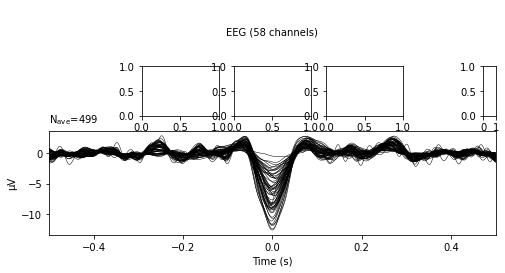

In [5]:
# TEST: run ICA
import mne_bids
from xarray_creator import _cut_noisy
from preprocessing 
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

# open raw data
task = 'baseline1'
bids_path = mne_bids.BIDSPath(subject='01', session='01', task=task, root='data/BIDS_data')
raw = mne_bids.read_raw_bids(bids_path, extra_params={'preload':True})
raw = _cut_noisy(raw, task, 'hun')
raw.filter(1,30)  # filter before ICA

# create eog evoked
eog_evoked = create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

ica = ICA(n_components=15, max_iter='auto', random_state=97)
ica.fit(raw)

ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
ica.plot_properties(raw, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw, show_scrollbars=False)

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_evoked)